# K-means for Item 

In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.feature_extraction import FeatureHasher
from kmodes.kprototypes import KPrototypes
import plotly.express as px


In [61]:
# 1) Caricamento e pulizia
item = pd.read_csv(
    '../../datasets/ml-100k/u.item',
    sep='|',
    encoding='latin-1', 
    names=[
        'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_url',
        'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
    ]
)
item = item.drop(columns=['IMDb_url','video_release_date'])


In [62]:
# 2) Gestione dei NaN sulla data
item['release_date'] = pd.to_datetime(item['release_date'], errors='coerce')
# Imputiamo i NaN con data fittizia basata sulla mediana
mediana_anno = item['release_date'].dt.year.median()
item['release_date'] = item['release_date'].fillna(pd.to_datetime(f'{int(mediana_anno)}-01-01'))


In [63]:
# 3) Estrai anno come numerico
item['release_year'] = item['release_date'].dt.year.astype(int)


In [64]:
# 4) Prepara le feature
generi = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# Matrice binaria dei generi
X_bin = item[generi].astype(int).values

# Normalizza l'anno in [0,1]
years = item[['release_year']].values.astype(float)
years_norm = MinMaxScaler().fit_transform(years)

# Combina in un unico array continuo per la silhouette euclidea
X_mix = np.hstack([X_bin, years_norm])


In [65]:
# 5) Itera sui valori di k per K-Prototypes
costs      = []
sil_scores = []
K_range    = range(2, 11)
cat_idx    = list(range(len(generi)))  # indici delle colonne categoriche in X

for k in K_range:
    # Fit K-Prototypes su dati misti (binari + anno numerico)
    kprot = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    labels = kprot.fit_predict(item[generi + ['release_year']], categorical=cat_idx)
    
    # Registra costo interno
    costs.append(kprot.cost_)
    
    # Calcola silhouette su X_mix (euclidea)
    sil = silhouette_score(X_mix, labels, metric='euclidean')
    sil_scores.append(sil)
    
    print(f'k={k} → cost={kprot.cost_:.0f}, silhouette={sil:.4f}')

k=2 → cost=74532, silhouette=0.1110
k=3 → cost=45301, silhouette=0.0796
k=4 → cost=34554, silhouette=0.0670
k=5 → cost=30198, silhouette=0.1809
k=6 → cost=27725, silhouette=0.2323
k=7 → cost=24140, silhouette=0.1289
k=8 → cost=22349, silhouette=0.1035
k=9 → cost=20821, silhouette=0.0907
k=10 → cost=19398, silhouette=0.1929


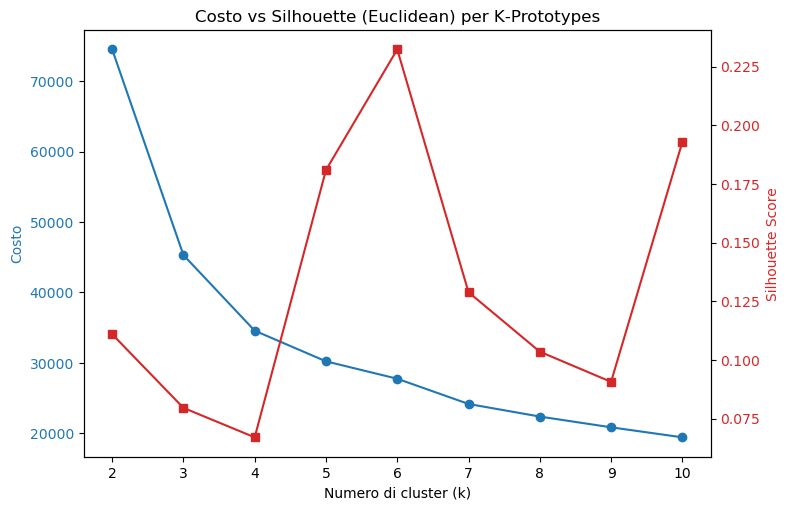

In [66]:
# 6) Grafico Costo vs Silhouette
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(K_range, costs, '-o', color='tab:blue', label='Costo')
ax1.set_xlabel('Numero di cluster (k)')
ax1.set_ylabel('Costo', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(K_range, sil_scores, '-s', color='tab:red', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Costo vs Silhouette (Euclidean) per K‑Prototypes')
plt.show()

In [67]:
# 1.1: Salva i label dell'ULTIMO modello
item['cluster_kproto'] = kprot.labels_  # usa direttamente i label finali

# 1.2: Dimensione di ogni cluster
cluster_sizes = item['cluster_kproto'].value_counts().sort_index()
print("Dimensione dei cluster:")
print(cluster_sizes)


Dimensione dei cluster:
cluster_kproto
0    546
1    112
2     34
3     58
4     45
5     62
6    367
7     46
8     34
9    378
Name: count, dtype: int64


d:\Download\Miniconda\Anaconda\envs\FDSML\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


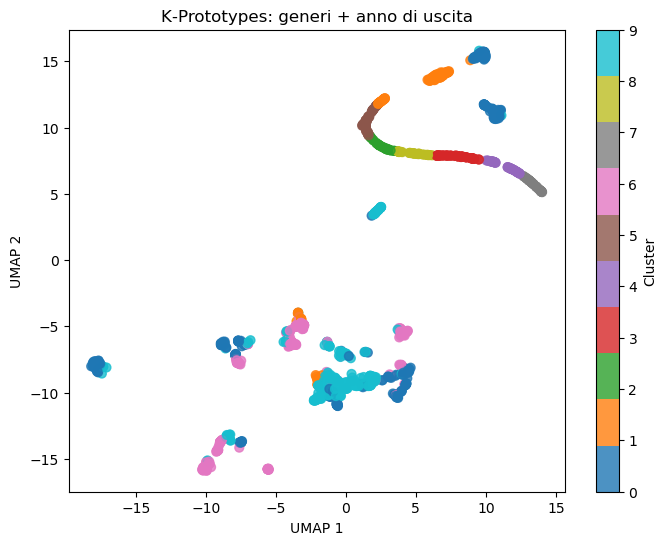

In [69]:
# 3) UMAP + plot dei cluster
X_bin = item[generi].astype(int).values
X_num = item[['release_year']].values
X_mix = np.hstack([X_bin, X_num])

# UMAP per ridurre a 2D
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_mix)

# Plot 2D
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    embedding[:,0], embedding[:,1],
    c=item['cluster_kproto'], cmap='tab10', s=40, alpha=0.8
)
plt.title('K‑Prototypes: generi + anno di uscita')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Colorbar con solo i cluster presenti
unique_clusters = np.sort(item['cluster_kproto'].unique())
cbar = plt.colorbar(scatter, ticks=unique_clusters)
cbar.set_label('Cluster')
plt.show()
